In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm
import scipy
import umap
from ripser import ripser
from persim import plot_diagrams

from utils import *
from methods import *
from models import *
from plotting_functions import *

In [3]:
# load trained model
model = torch.load('./saved-models/JV100')

# ---> OVERLOAD PHASES <---
# random uniform
#phases = model.unit_cell.sample(6)
#phases = np.random.uniform(0,0.2,size=model.phases.shape)
#model.phases = torch.nn.Parameter(torch.tensor(phases,dtype=torch.float32))
#mask = torch.linalg.norm(model.phases+0.2,axis=-1) > 0.4
#model.phases = torch.nn.Parameter(model.phases[mask])
# ---

phases = model.phases.clone().detach().numpy()
wrapped_phases = model.unit_cell.wrap(phases)

[(<Figure size 640x480 with 3 Axes>, <AxesSubplot:>),
 (<Figure size 640x480 with 3 Axes>, <AxesSubplot:>),
 (<Figure size 640x480 with 3 Axes>, <AxesSubplot:>)]

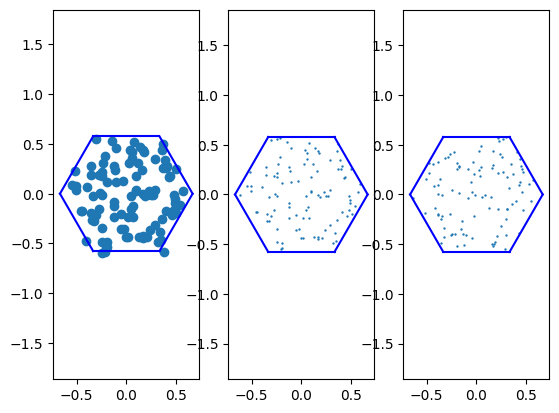

In [4]:
fig, axs = plt.subplots(ncols=3)
axs[0].scatter(*phases.T)
axs[1].scatter(*wrapped_phases.T,s=0.5)
axs[2].scatter(*model.unit_cell.sample(phases.shape[0]).T,s=0.5)
[axs[i].axis('equal') for i in range(len(axs))]

[model.unit_cell.plot(fig,axs[i]) for i in range(len(axs))]

### Test (Linear) decoding performance

In [5]:
def test_decoding(model,nsamples_space=10000):
    r = model.unit_cell.sample(nsamples_space)
    activity = model.forward(torch.tensor(r,dtype=torch.float32))
    model.train_decoder(torch.tensor(r,dtype=torch.float32))
    r_pred = model.decode(activity)
    r_pred = r_pred.detach().numpy()
    r_wrapped = model.unit_cell.wrap(r_pred)
    return r, model.unit_cell.geodesic(r,r_wrapped), np.linalg.norm(r-r_wrapped,axis=-1)

0.4136834930975002 0.5653986209115849


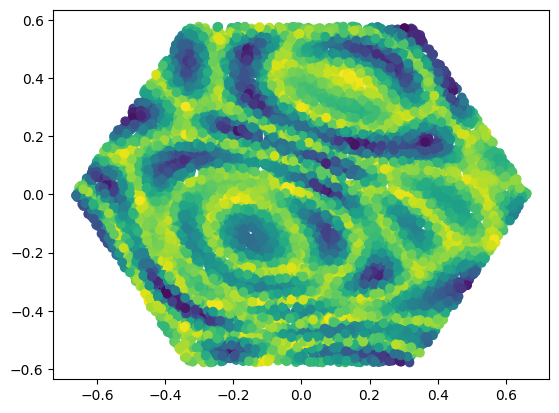

In [6]:
r, decoding_error, decoding_error_euclidean = test_decoding(model)
print(np.mean(decoding_error), np.mean(decoding_error_euclidean))
plt.scatter(*r.T,c=decoding_error)

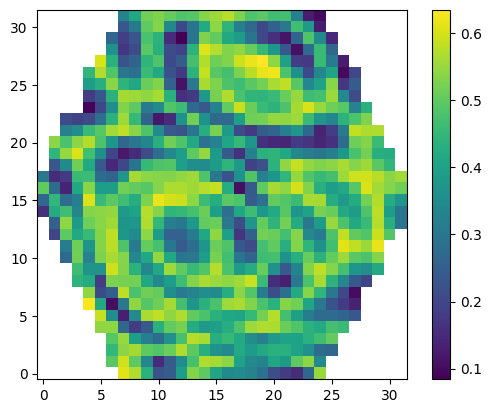

In [7]:
hist2d = scipy.stats.binned_statistic_2d(*r.T,decoding_error,bins=32).statistic
plt.imshow(hist2d.T,origin='lower')
plt.colorbar()

### Show The Jacobian

In [8]:
def test_detJ(model,nsamples_space=10000):
    r = model.unit_cell.sample(nsamples_space)
    J = model.jacobian(torch.tensor(r,dtype=torch.float32))
    det_J = model.the_jacobian(J)
    return r,det_J.detach().numpy()

In [9]:
r,detJ = test_detJ(model)

Text(0.5, 1.0, 'Var(det(J^T J)) = 2.578832147825949e-10')

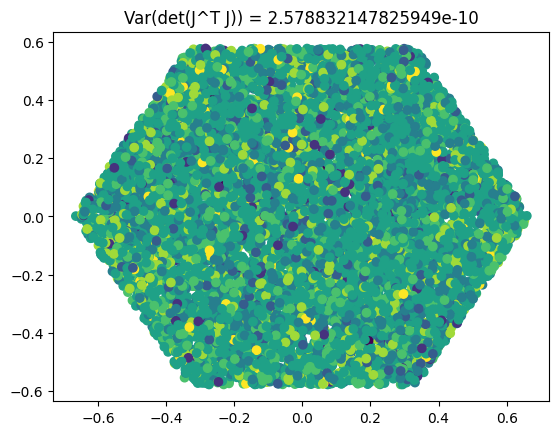

In [10]:
plt.scatter(*r.T,c=detJ)
plt.title(f"Var(det(J^T J)) = {np.var(detJ)}")

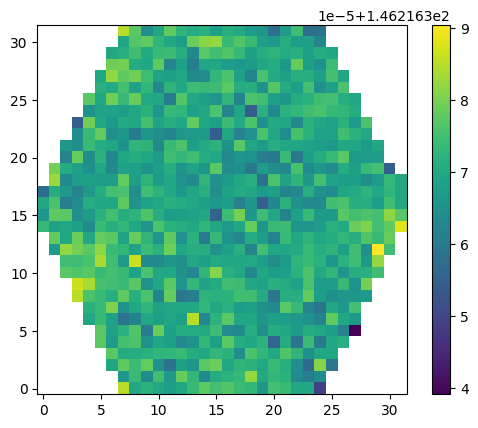

In [11]:
hist2d = scipy.stats.binned_statistic_2d(*r.T,detJ,bins=32).statistic
plt.imshow(hist2d.T,origin='lower')
plt.colorbar()

### Show (low-dimensional projection) manifold

In [12]:
def show_manifold(model,nsamples_space=10000):
    #r = np.random.uniform(-1.2/2,1.2/2,size=(64**2,2))
    #r = model.unit_cell.sample(nsamples_space)
    #r = create_board(1.2,to_torch_tensor=False).reshape(-1,2)
    #r = r[model.unit_cell.is_in_hexagon(r)]
    r = model.unit_cell.mesh(100)
    activity = model.forward(torch.tensor(r,dtype=torch.float32)).detach().numpy()
    projection = umap.UMAP(n_neighbors=100,n_components=3)
    return projection.fit_transform(activity), projection, activity

In [13]:
manifold, projection, activity = show_manifold(model)

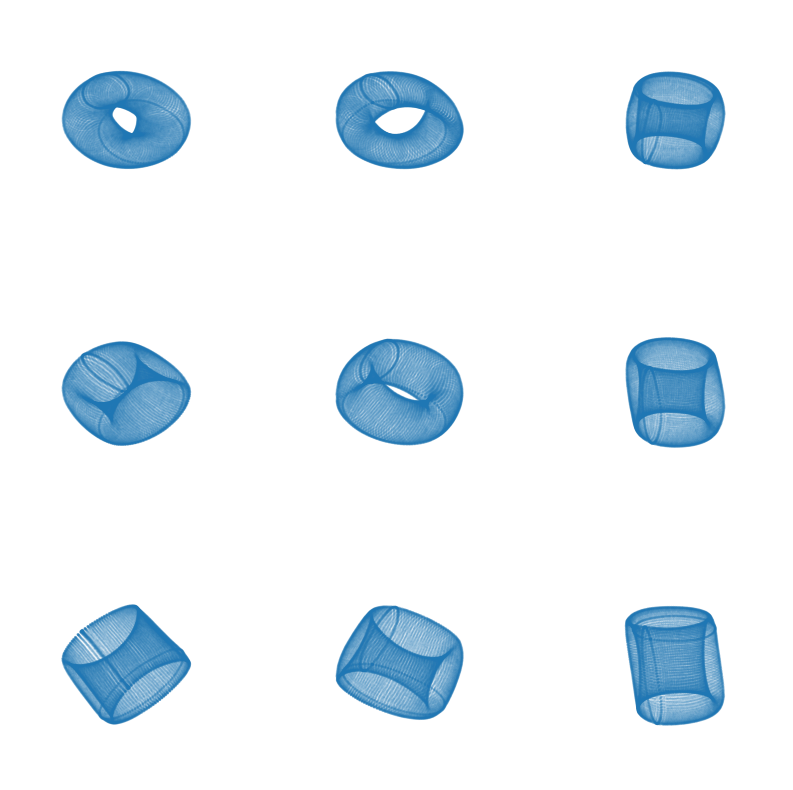

In [14]:
scatter3d(manifold,ncols=3,nrows=3,azim_elev_title=False,figsize=(10,10),alpha=0.2);

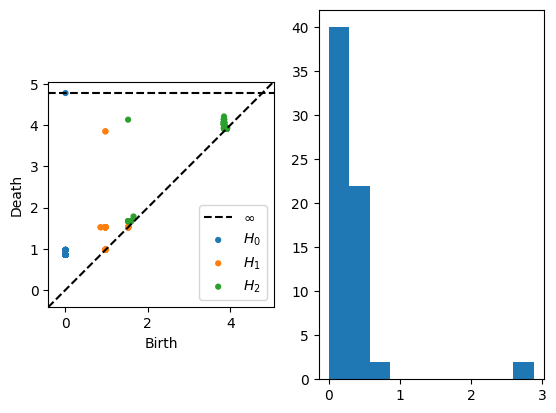

In [15]:
fig,axs = plt.subplots(ncols=2)
#dgms = ripser(g,maxdim=2,n_perm=150)['dgms']
dgms = ripser(activity,maxdim=2,n_perm=150)['dgms']
plot_diagrams(dgms, show=False, ax=axs[0])
axs[1].hist(dgms[1][:,1] - dgms[1][:,0]);

### Test whether distribution is uniform

In [118]:
def ripleys_choose_radius(radius,unit_cell):
    return lambda X,Y: unit_cell.ripleys(X,radius) - unit_cell.ripleys(Y,radius)

In [119]:
random_uniform_phases = model.unit_cell.sample(phases.shape[0])

In [120]:
radiuses = np.linspace(0,model.unit_cell.radius,11)[1:]
stats,ps,H0s = [],[],[]
for radius in radiuses:
    ripleys_statistic = ripleys_choose_radius(radius,model.unit_cell)
    stat, p, H0 = permutation_test(wrapped_phases,random_uniform_phases,
                                   ripleys_statistic,nperms=100,alternative='greater')
    stats.append(stat)
    ps.append(p)
    H0s.append(H0)
stats,ps,H0s = np.array(stats), np.array(ps), np.array(H0s)

100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 104.06it/s]


0.594059405940594


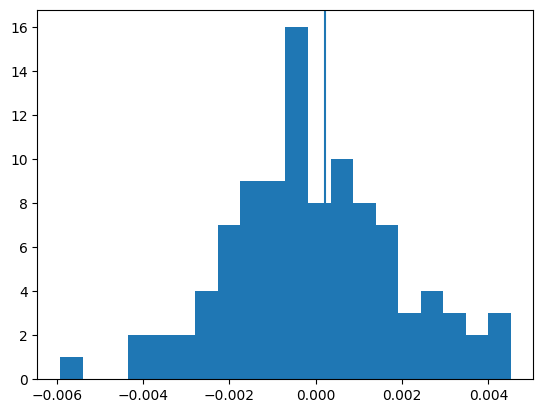

In [121]:
print(p)
plt.hist(H0,bins=20)
plt.axvline(stat)

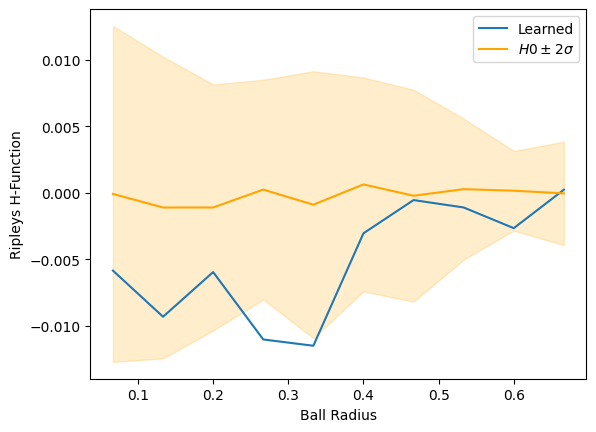

In [122]:
plt.plot(radiuses,stats,label='Learned')
mu0 = np.mean(H0s,axis=-1)
s0 = np.std(H0s,axis=-1)
plt.plot(radiuses,mu0,label='$H0\pm2\sigma$',color='orange')
plt.fill_between(radiuses,mu0-2*s0,mu0+2*s0,alpha=0.2,color='orange')
plt.xlabel('Ball Radius')
plt.ylabel('Ripleys H-Function')
plt.legend()